<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook</p></tp>
            <tp><p style="font-size:150%;text-align:center">Agente basado en el conocimiento</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---


## Objetivo <a class="anchor" id="inicio"></a>

En este notebook ejemplificaremos un agente basado en el conocimiento. Usaremos el problema del laberinto como ejemplo.


## Secciones

Desarrollaremos la explicación en las siguientes secciones:

1. [El ambiente del laberinto](#lab)
2. [Un agente basado en el conocimiento](#agenteKB)
3. [Creando un mapa mental](#mapa)
4. [Estimación de estados](#esti)

## El ambiente del laberinto <a class="anchor" id="lab"></a>

([Volver al inicio](#inicio))

En el problema del laberinto la percepción del agente está basada en una colección de sensores que se encienden cuando detectan un obstáculo, organizados de la siguiente manera:

`[sensor frontal, sensor izquierdo, sensor derecho, sensor trasero]`

Los valores de los sensores se obtienen mediante el método `para_sentidos()` de la clase `Laberinto` y se almacenan en el atributo `perceptos` de un objeto de clase `Agente`. Veamos la implementación de la percepción del agente directamente en el ejemplo donde el agente comienza en la casilla $(11,11)$:

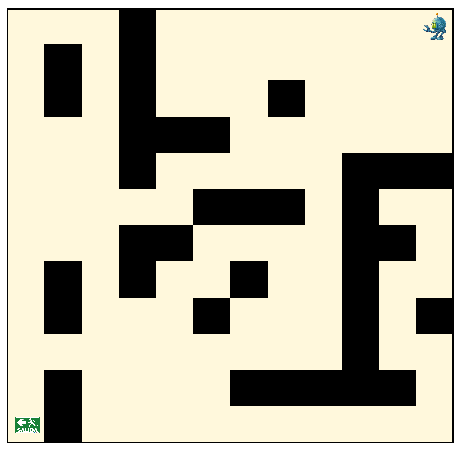

La lista de sensores es:
[sensor frontal, sensor izquierdo, sensor derecho, sensor trasero]
Los valores en la casilla (11,11) son:
[False, False, True, True]


In [1]:
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
lab.pintar()
agente = Agente()
agente.perceptos = lab.para_sentidos()
print('La lista de sensores es:')
print('[sensor frontal, sensor izquierdo, sensor derecho, sensor trasero]')
print('Los valores en la casilla (11,11) son:')
print(agente.perceptos)

Las acciones posibles del agente son:

* adelante: el agente avanza una casilla.
* voltearIzquierda: el agente gira 90º en contra de las manecillas del reloj.
* voltearDerecha: el agente gira 90º a favor de las manecillas del reloj.
* salir: si el agente está en la salida, fin del juego.

Cada acción del agente tiene un efecto en el entorno, implementado mediante el método `transicion()` de la clase `Laberinto`. Veamos un ejemplo en donde el agente parte de la casilla $(11,11)$ y deambula un poco por el laberinto:

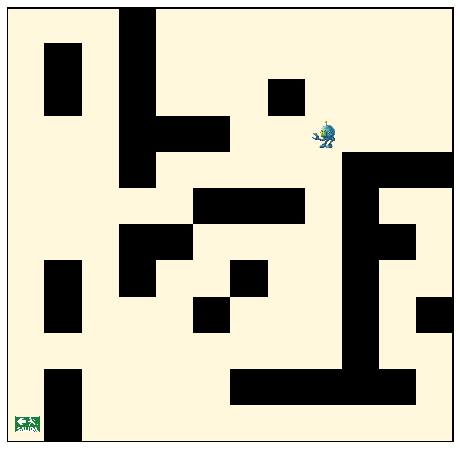

In [2]:
from agentes import *
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt

lab = Laberinto(pos_inicial=(11,11))
acciones = ['adelante', 'adelante', 'voltearIzquierda', 
            'adelante', 'adelante', 'adelante', 'voltearDerecha', 'adelante']

lab.pintar()

for a in acciones:
    lab.transicion(a)
    clear_output(wait=True)
    lab.pintar()
    plt.show()
#    sleep(.25)    

---

## Un agente basado en conocimiento <a class="anchor" id="agenteKB"></a>

([Volver al inicio](#inicio))

Vamos a crear un agente basado en conocimiento para resolver el problema del laberinto. Veremos que no es tan sencillo como el de reflejo simple. El programa de agente en este caso no es una conexión directa entre perceptos y acciones, pues en la mitad está un modelo del mundo. El modelo será un conjunto de enunciados lógicos en una base de conocimiento, como vimos en el notebook anterior. 

Son varias las ventajas de este tipo de agente respecto al de respuesta simple:

* Primero, las proposiciones que definen el modelo no requieren estar conectadas directamente a los perceptos y a las acciones. Esto permite definir nuevas categorías para armar restricciones de mayor nivel de abstracción. 
* Además, es posible tener una memoria para almacenar información que pueda ser utilizada muchos turnos después. 
* Adicionalmente, la base de conocimiento permite hacer razonamientos para obtener nueva información a partir de la información almacenada.

Para definir el programa requerimos:

* Interpretar los perceptos como una fórmula lógica.
* Una base de conocimiento con las reglas que definen la dinámica del agente en el mundo.
* Una manera de hacer consultas en la base de conocimiento para determinar nueva información.
* Un entramado de reglas, como en el programa de reflejo simple, que defina qué va a hacer el agente y cómo usará la información de su base de conocimiento para decidir sus acciones.

Veamos ahora uno a uno los componentes del programa de agente.

### Interpretación de los perceptos

La clase `Agente` ya trae definido un método `interp_percepto()`, el cual interpreta los perceptos como letras proposicionales, con la siguiente representación:

* frn_bloq es verdadero sii el sensor de enfrente del robot detecta un obstáculo.
* izq_bloq es verdadero sii el sensor de la izquierda del robot detecta un obstáculo.
* der_bloq es verdadero sii el sensor de la derecha del robot detecta un obstáculo.
* atr_bloq es verdadero sii el sensor de atrás del robot detecta un obstáculo.

In [3]:
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
agente.perceptos = lab.para_sentidos()
agente.interp_percepto()

'-frn_bloq_1Y-izq_bloq_1Yder_bloq_1Yatr_bloq_1'

Observe que cada letra trae un número asociado. Este número es el número del turno:

In [4]:
agente.turno = 3
agente.interp_percepto()

'-frn_bloq_3Y-izq_bloq_3Yder_bloq_3Yatr_bloq_3'

Asociar un turno es indispensable, toda vez que en lógica proposicional los valores de las letras proposionales no cambian nunca, pero el valor de los sensores sí. Por esta razón, la representación correcta de los perceptos es la siguiente:

* frn_bloq_n es verdadero sii el sensor de enfrente del robot detecta un obstáculo en el turno n.
* izq_bloq_n es verdadero sii el sensor de la izquierda del robot no detecta un obstáculo en el turno n.
* der_bloq_n es verdadero sii el sensor de la derecha del robot detecta un obstáculo en el turno n.
* atr_bloq_n es verdadero sii el sensor de atrás del robot detecta un obstáculo en el turno n.

### La base de conocimiento

El modelo define la dinámica del mundo y del agente. En este caso sencillo, dado que el entorno es estático, sólo requerimos la dinámica del agente. Es decir, solo tenemos que representar lo que debe hacer el agente de acuerdo a alguna condición. Estas reglas estarán descritas mediante una fórmula lógica. 

Observe que tenemos una restricción importante aquí, toda vez que nuestras fórmulas solo aceptan un antecedente conformado por conjunciones de literales y un consecuente con un solo literal. La fórmula que representa la regla "Si el frente no está bloqueado y el flanco derecho está bloqueado, avanzar una casilla" es la siguiente:

In [5]:
def conocimiento(self):
    turno = agente.turno
    formulas = [
        # Si el frente no está bloqueado y el flanco derecho está
        # bloqueado, avanzar una casilla
        f'-frn_bloq_{turno}Yder_bloq_{turno}>adelante_{turno}',
    ]
    return formulas

setattr(Agente, 'conocimiento', conocimiento)

agente = Agente()
agente.conocimiento()

['-frn_bloq_1Yder_bloq_1>adelante_1']

**Nota:** Observe que las letras proposicionales que representan acciones también están indexadas por el turno.

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Implemente una fórmula para cada una de las siguientes reglas e inclúyalas en el conocimiento del agente:

* "Si el frente no está bloqueado y el flanco derecho está bloqueado, avanzar una casilla"
* "Si el frente y el flanco derecho están bloqueados y el flanco izquierdo no está bloqueado, voltear a la izquierda"
* "Si el flanco derecho no está bloqueado, voltear a la derecha"

---

In [6]:
def conocimiento(self):
    turno = agente.turno
    formulas = [
        # Si el frente no está bloqueado y el flanco derecho está
        # bloqueado, avanzar una casilla
        f'-frn_bloq_{turno}Yder_bloq_{turno}>adelante_{turno}',
        f'frn_bloq_{turno}Yder_bloq_{turno}Y-izq_bloq_{turno}>voltearIzquierda_{turno}',
        f'-der_bloq_{turno}>voltearDerecha_{turno}',
    ]
    return formulas

setattr(Agente, 'conocimiento', conocimiento)

agente = Agente()
agente.conocimiento()

['-frn_bloq_1Yder_bloq_1>adelante_1',
 'frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1',
 '-der_bloq_1>voltearDerecha_1']

### Consultas

La manera de usar la base de conocimiento es mediante consultas. El resultado de una consulta es `True` o `False`. Una consulta se hace con un objetivo, el cual requiere un literal y la condición de si este se deduce o no a partir de la información en la base de conocimiento. Por ejemplo, un objetivo puede ser saber si al deducir `frn_libre_1` a partir de la base de conocimiento, mediante el algoritmo `backward_chaining`, da como resultado `success`. Si sí, la consulta retorna `True`. 

El otro tipo de objetivo sería saber si el resultado es `failure`. Si `frn_libre_1` no se puede deducir y da como resultado `failure`, entonces el resultado de la consulta es `True`.

Observe que la función `ASK` ya está implementada en la librería `Logica`.

Veámos las consultas que haremos para nuestro caso particular. En primer lugar, definimos la base de conocimiento:

In [7]:
from logica import *
from agentes import *

lab = Laberinto()
agente = Agente()
formulas = agente.conocimiento()
base_con = LPQuery(formulas)
agente.base = base_con
agente.perceptos = lab.para_sentidos()
agente.base.TELL(agente.interp_percepto())
print(agente.base)

Hechos:
-frn_bloq_1
-izq_bloq_1
der_bloq_1
atr_bloq_1

Reglas:
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1



Ahora preguntamos si la acción que debemos hacer es voltear a la derecha:

In [8]:
objetivo = 'voltearDerecha_'+str(agente.turno)
ASK(objetivo, 'success', agente.base)

False

Luego, preguntaremos si debemos seguir adelante:

In [9]:
objetivo = f'adelante_{agente.turno}'
ASK(objetivo, 'success', agente.base)

True

Finalmente, si la anterior consulta no hubiera resultado en `True`, seguiríamos con la consulta de si debemos voltear a la izquierda:

In [10]:
objetivo = 'voltearIzquierda_'+str(agente.turno)
ASK(objetivo, 'success', agente.base)

False

### Definición del programa de agente

El programa de agente está basado en hacer consultas para determinar qué acción debe tomar el agente, de acuerdo a la información disponibe en su base de conocimiento. El orden en que hacemos las consultas es importante. Solo si una consulta falla, pasaremos a hacer la consulta siguiente. Vamos a definir la siguiente prioridad:

* Consultar si debo voltear a la derecha.
* Consultar si debo ir adelante.
* Consultar si debo voltear a la izquierda.

**Nota:** Observe que estamos dejando por fuera la consulta más importante, que es la de si debo salir. Esto lo podremos hacer una vez hayamos desarrollado el mapa mental, lo cual haremos más adelante.

In [11]:
def programaKB(self):
    turno = self.turno
    if ASK(f'voltearDerecha_{turno}', 'success', self.base):
        self.acciones.append('voltearDerecha')
        self.base.TELL(f'voltearDerecha_{turno}')
    elif ASK(f'adelante_{turno}', 'success', self.base):
        self.acciones.append('adelante')
        self.base.TELL(f'adelante_{turno}')
    elif ASK(f'voltearIzquierda_{turno}', 'success', self.base):
        self.acciones.append('voltearIzquierda')
        self.base.TELL(f'voltearIzquierda_{turno}')
    else:
        raise Exception('¡Caso no considerado!', self.interp_percepto())
setattr(Agente, 'programa', programaKB)

Estudiemos las primeras tres rondas y lo que pasa con la base de conocimiento:

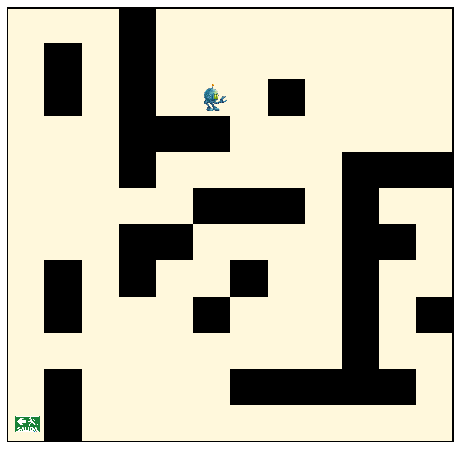

------- Turno 1 -------
Hechos:
-frn_bloq_1
-izq_bloq_1
der_bloq_1
-atr_bloq_1

Reglas:
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1

voltearDerecha? False
adelante? True
voltearIzquierda? False


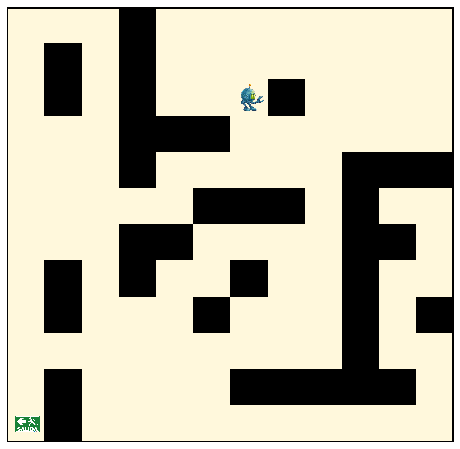

------- Turno 2 -------
Hechos:
-frn_bloq_1
-izq_bloq_1
der_bloq_1
-atr_bloq_1
adelante_1
frn_bloq_2
-izq_bloq_2
-der_bloq_2
-atr_bloq_2

Reglas:
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1
-frn_bloq_2Yder_bloq_2>adelante_2
frn_bloq_2Yder_bloq_2Y-izq_bloq_2>voltearIzquierda_2
-der_bloq_2>voltearDerecha_2

voltearDerecha? True
adelante? False
voltearIzquierda? False


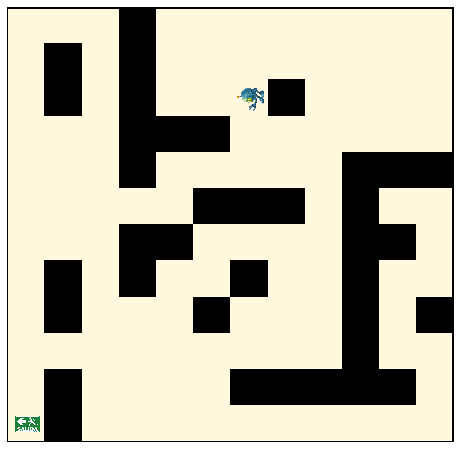

------- Turno 3 -------
Hechos:
-frn_bloq_1
-izq_bloq_1
der_bloq_1
-atr_bloq_1
adelante_1
frn_bloq_2
-izq_bloq_2
-der_bloq_2
-atr_bloq_2
voltearDerecha_2
-frn_bloq_3
izq_bloq_3
-der_bloq_3
-atr_bloq_3

Reglas:
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1
-frn_bloq_1Yder_bloq_1>adelante_1
frn_bloq_1Yder_bloq_1Y-izq_bloq_1>voltearIzquierda_1
-der_bloq_1>voltearDerecha_1
-frn_bloq_2Yder_bloq_2>adelante_2
frn_bloq_2Yder_bloq_2Y-izq_bloq_2>voltearIzquierda_2
-der_bloq_2>voltearDerecha_2
-frn_bloq_3Yder_bloq_3>adelante_3
frn_bloq_3Yder_bloq_3Y-izq_bloq_3>voltearIzquierda_3
-der_bloq_3>voltearDerecha_3

voltearDerecha? True
adelante? False
voltearIzquierda? False


In [12]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(5,9), dir_agente='este')
agente = Agente()
formulas = agente.conocimiento()
base_con = LPQuery(formulas)
agente.base = base_con

for i in range(3):
    lab.pintar()
    agente.perceptos = lab.para_sentidos()
    agente.base.TELL(agente.interp_percepto())
    for f in agente.conocimiento():
        agente.base.TELL(f)
    print(f'------- Turno {i+1} -------')
    print(agente.base)
    print('voltearDerecha?', ASK('voltearDerecha_'+str(agente.turno), 'success', agente.base))
    print('adelante?', ASK('adelante_'+str(agente.turno), 'success', agente.base))
    print('voltearIzquierda?', ASK('voltearIzquierda_'+str(agente.turno), 'success', agente.base))
    a = agente.reaccionar()
    lab.transicion(a)


Para finalizar, pongamos a andar al agente por el laberinto desde la casilla $(11,11)$:

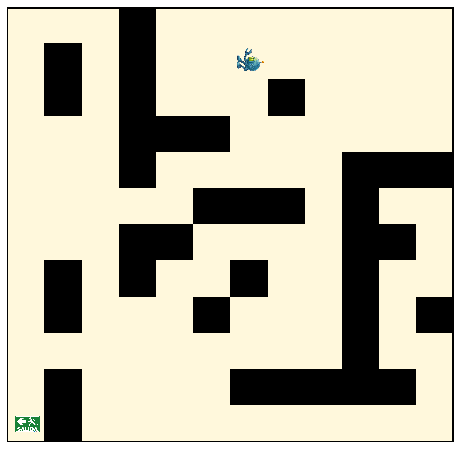

In [13]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
formulas = agente.conocimiento()
base_con = LPQuery(formulas)
agente.base = base_con

for i in range(30):
    if lab.activo:
        clear_output(wait=True)
        lab.pintar()
        agente.perceptos = lab.para_sentidos()
        agente.base.TELL(agente.interp_percepto())
        for f in agente.conocimiento():
            agente.base.TELL(f)
        a = agente.reaccionar()
        lab.transicion(a)
#        sleep(.25) 


<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Para arreglar el funcionamiento del agente necesitamos hacer lo siguiente:

* Modifique la primera regla en la base de conocimiento para que diga "Si el frente no está bloqueado, avanzar una casilla".
* Modifique la segunda regla en la base de conocimiento para que diga "Si el frente está bloqueado y la izquierda no, avanzar una casilla".
* Modifique la tercera regla en la base de conocimiento para que diga que "Si el flanco derecho no está bloqueado pero estaba bloqueado el turno pasado, voltear a la derecha".


Corra de nuevo el programa de agente desde la casilla $(11,11)$ para verificar el funcionamiento.

In [14]:
def conocimiento(self):
    turno = agente.turno
    formulas = [
        # Si el frente no está bloqueado, avanzar una casilla
        f'-frn_bloq_{turno}>adelante_{turno}',
        
        # Si el frente está bloqueado y la izquierda no, 
        # voltear a la izquierda
        f'frn_bloq_{turno}Y-izq_bloq_{turno}>voltearIzquierda_{turno}',
        
        # Si el flanco derecho no está bloqueado pero estaba
        # bloqueado el turno pasado, voltear a la derecha 
        f'-der_bloq_{turno}Yder_bloq_{turno-1}>voltearDerecha_{turno}',
    ]
    return formulas

setattr(Agente, 'conocimiento', conocimiento)

agente = Agente()
agente.conocimiento()

['-frn_bloq_1>adelante_1',
 'frn_bloq_1Y-izq_bloq_1>voltearIzquierda_1',
 '-der_bloq_1Yder_bloq_0>voltearDerecha_1']

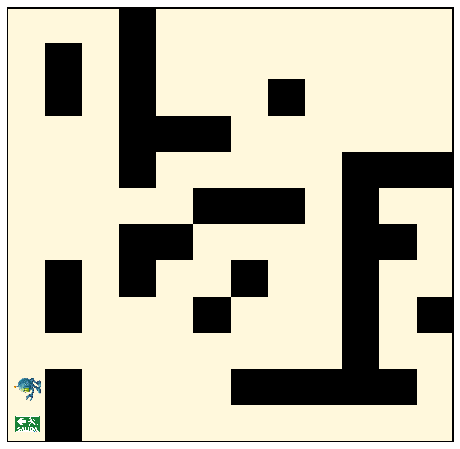

In [15]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
formulas = agente.conocimiento()
base_con = LPQuery(formulas)
agente.base = base_con

for i in range(45):
    if lab.activo:
        clear_output(wait=True)
        lab.pintar()
        agente.perceptos = lab.para_sentidos()
        agente.base.TELL(agente.interp_percepto())
        for f in agente.conocimiento():
            agente.base.TELL(f)
        a = agente.reaccionar()
        lab.transicion(a)
#        sleep(.25)
    else:
        break

---

### Incompatibilidad de reglas

Observe que las reglas 1 y 3 de la base de conocimiento 

$\neg$frn_bloq$_t$ $\to$ adelante$_t$

y 

$\neg$der_bloq$_t$ $\wedge$ der_bloq$_{t-1}$ $\to$ voltearDerecha$_t$

producen acciones contradictorias en una situación en la cual la fórmula

$\neg$frn_bloq$_t$ $\wedge$ $\neg$der_bloq$_t$ $\wedge$ der_bloq$_{t-1}$

sea verdadera.

El programa de agente `programaKB` está diseñado para primero verificar si el agente voltea a la derecha. En caso afirmativo, no verifica más opciones. No obstante, **la base de conocimiento permite derivar las dos acciones**.

Es necesario arreglar esta situación, de tal manera que una y solo una regla sea aplicable en cada situación. Esto se logra modificando la primera regla, de tal manera que se cumpla en los casos en que no se cumple la tercera. Esto se logra mediante la fórmula:

$\neg$frn_bloq$_t$ $\wedge$ (der_bloq$_t$ $\vee$ $\neg$der_bloq$_{t-1}$) $\to$ adelante$_t$

Como esta regla transgrede la restricción que hemos hecho sobre las reglas, debemos modificarla. El mismo efecto se logra usando dos reglas así:

* $\neg$frn_bloq$_t$ $\wedge$ der_bloq$_t$ $\to$ adelante$_t$
* $\neg$frn_bloq$_t$ $\wedge$ $\neg$der_bloq$_t$ $\wedge$ $\neg$der_bloq$_{t-1}$ $\to$ adelante$_t$

Es necesario hacer lo mismo con la segunda regla. 

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Modifique la base de conocimiento del agente para solucionar el problema de reglas incompatibles, de acuerdo a la explicación anterior.

---

In [16]:
def conocimiento(self):
    turno = agente.turno
    formulas = [
        # Si el frente no está bloqueado, avanzar una casilla
        f'-frn_bloq_{turno}Yder_bloq_{turno}>adelante_{turno}',
        f'-frn_bloq_{turno}Y-der_bloq_{turno}Y-der_bloq_{turno-1}>adelante_{turno}',

        
        # Si el frente está bloqueado y la izquierda no, 
        # voltear a la izquierda
        f'frn_bloq_{turno}Y-izq_bloq_{turno}Yder_bloq_{turno}>voltearIzquierda_{turno}',
        f'frn_bloq_{turno}Y-izq_bloq_{turno}Y-der_bloq_{turno}Y-der_bloq_{turno-1}>voltearIzquierda_{turno}',

        
        # Si el flanco derecho no está bloqueado pero estaba
        # bloqueado el turno pasado, voltear a la derecha 
        f'-der_bloq_{turno}Yder_bloq_{turno-1}>voltearDerecha_{turno}',
    ]
    return formulas

setattr(Agente, 'conocimiento', conocimiento)

agente = Agente()
agente.conocimiento()

['-frn_bloq_1Yder_bloq_1>adelante_1',
 '-frn_bloq_1Y-der_bloq_1Y-der_bloq_0>adelante_1',
 'frn_bloq_1Y-izq_bloq_1Yder_bloq_1>voltearIzquierda_1',
 'frn_bloq_1Y-izq_bloq_1Y-der_bloq_1Y-der_bloq_0>voltearIzquierda_1',
 '-der_bloq_1Yder_bloq_0>voltearDerecha_1']

## Creando un mapa mental <a class="anchor" id="mapa"></a>

([Volver al inicio](#inicio))

El programa de agente basado en conocimiento que hemos escrito permite solucionar el problema desde varias casillas, pero no desde $(3,3)$. Para solucionar el problema del laberinto debemos considerar qué casillas visitamos y cuáles no. Esto es, necesitamos ir creando un mapa mental con la información de (i) la posición del agente y (ii) qué casillas ha visitado. Este mapa irá quedando grabado en una serie de letras proposicionales que representan la casilla en que está el agente. Para lograr esto, desarrollaremos la base de conocimiento de la siguiente manera. 

Para controlar la posición del agente, es necesario usar la información de qué acción realiza y en qué dirección está mirando. Entonces necesitamos cuatro letras proposicionales que representen las cuatro direcciones cardinales:

* midando_o_t es verdadero sii el agente está mirando al oeste en el turno $t$.
* midando_e_t es verdadero sii el agente está mirando al este en el turno $t$.
* midando_s_t es verdadero sii el agente está mirando al sur en el turno $t$.
* midando_n_t es verdadero sii el agente está mirando al norte en el turno $t$.

### Dirección en que mira (fluente_mirando)

Veamos las reglas que determinan el comportamiento de la dirección del agente. Las primeras dicen que la acción de avanzar una casilla no cambia la dirección:

* mirando_o$_t$ $\wedge$ adelante$_t$ $\to$ mirando_o$_{t+1}$
* mirando_s$_t$ $\wedge$ adelante$_t$ $\to$ mirando_s$_{t+1}$
* mirando_e$_t$ $\wedge$ adelante$_t$ $\to$ mirando_e$_{t+1}$
* mirando_n$_t$ $\wedge$ adelante$_t$ $\to$ mirando_n$_{t+1}$


In [17]:
def fluente_mirando(turno):
    turno = agente.turno
    formulas = [
        f'mirando_o_{turno}Yadelante_{turno}>mirando_o_{turno+1}',
        f'mirando_s_{turno}Yadelante_{turno}>mirando_s_{turno+1}',
        f'mirando_e_{turno}Yadelante_{turno}>mirando_e_{turno+1}',
        f'mirando_n_{turno}Yadelante_{turno}>mirando_n_{turno+1}',
    ]
    return formulas

setattr(Agente, 'fluente_mirando', fluente_mirando)

agente = Agente()
agente.fluente_mirando()

['mirando_o_1Yadelante_1>mirando_o_2',
 'mirando_s_1Yadelante_1>mirando_s_2',
 'mirando_e_1Yadelante_1>mirando_e_2',
 'mirando_n_1Yadelante_1>mirando_n_2']

También tenemos las siguientes reglas, que controlan el cambio de dirección con la acción de voltear 90º a la izquierda:

* mirando_o$_t$ $\wedge$ voltearIzquierda$_t$ $\to$ mirando_s$_{t+1}$
* mirando_s$_t$ $\wedge$ voltearIzquierda$_t$ $\to$ mirando_e$_{t+1}$
* mirando_e$_t$ $\wedge$ voltearIzquierda$_t$ $\to$ mirando_n$_{t+1}$
* mirando_n$_t$ $\wedge$ voltearIzquierda$_t$ $\to$ mirando_o$_{t+1}$

Y lo mismo con la acción de voltear a la derecha:

* mirando_o$_t$ $\wedge$ voltearDerecha$_t$ $\to$ mirando_n$_{t+1}$
* mirando_n$_t$ $\wedge$ voltearDerecha$_t$ $\to$ mirando_e$_{t+1}$
* mirando_e$_t$ $\wedge$ voltearDerecha$_t$ $\to$ mirando_s$_{t+1}$
* mirando_s$_t$ $\wedge$ voltearDerecha$_t$ $\to$ mirando_o$_{t+1}$

<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente los dos últimos tipos de reglas para el fuente $mirando$. Ponga a andar al agente y visualice la dirección en que está el agente de acuerdo a la base de conocimiento para comprobar que las reglas quedaron correctas.

In [18]:
def fluente_mirando(turno):
    turno = agente.turno
    formulas = [
        f'mirando_o_{turno}Yadelante_{turno}>mirando_o_{turno+1}',
        f'mirando_s_{turno}Yadelante_{turno}>mirando_s_{turno+1}',
        f'mirando_e_{turno}Yadelante_{turno}>mirando_e_{turno+1}',
        f'mirando_n_{turno}Yadelante_{turno}>mirando_n_{turno+1}',
        
        # AQUÍ LOS OTROS DOS TIPOS DE REGLAS
        f'mirando_o_{turno}YvoltearIzquierda_{turno}>mirando_s_{turno+1}',
        f'mirando_s_{turno}YvoltearIzquierda_{turno}>mirando_e_{turno+1}',
        f'mirando_e_{turno}YvoltearIzquierda_{turno}>mirando_n_{turno+1}',
        f'mirando_n_{turno}YvoltearIzquierda_{turno}>mirando_o_{turno+1}',
        
        f'mirando_o_{turno}YvolteaDerecha_{turno}>mirando_n_{turno+1}',
        f'mirando_n_{turno}YvolteaDerecha_{turno}>mirando_e_{turno+1}',
        f'mirando_e_{turno}YvolteaDerecha_{turno}>mirando_s_{turno+1}',
        f'mirando_s_{turno}YvolteaDerecha_{turno}>mirando_o_{turno+1}',
        # AQUÍ TERMINA SU CÓDIGO
    ]
    return formulas

setattr(Agente, 'fluente_mirando', fluente_mirando)

In [ ]:
        # AQUÍ LOS OTROS DOS TIPOS DE REGLAS
        
        f'mirando_o_{turno}YvoltearIzquierda_{turno}>mirando_s_{turno+1}',
        f'mirando_s_{turno}YvoltearIzquierda_{turno}>mirando_e_{turno+1}',
        f'mirando_e_{turno}YvoltearIzquierda_{turno}>mirando_n_{turno+1}',
        f'mirando_n_{turno}YvoltearIzquierda_{turno}>mirando_o_{turno+1}',
        
        f'mirando_o_{turno}YvoltearDerecha_{turno}>mirando_n_{turno+1}',
        f'mirando_n_{turno}YvoltearDerecha_{turno}>mirando_e_{turno+1}',
        f'mirando_e_{turno}YvoltearDerecha_{turno}>mirando_s_{turno+1}',
        f'mirando_s_{turno}YvoltearDerecha_{turno}>mirando_o_{turno+1}',        
        # AQUÍ TERMINA SU CÓDIGO

Dirreción del agente: None


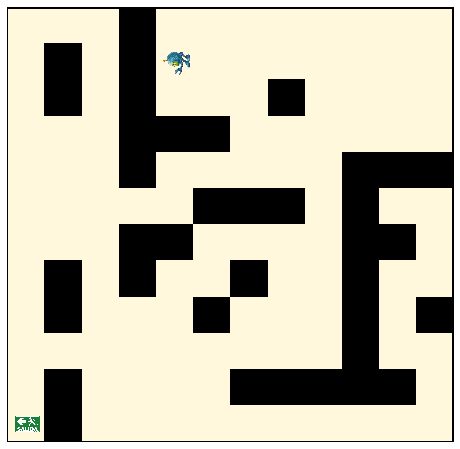

¡Listo!


In [20]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
formulas = agente.conocimiento()
agente.base = LPQuery(formulas)
agente.base.TELL(f'mirando_o_{agente.turno}')

for i in range(10):
    if lab.activo:
        clear_output(wait=True)
        confirmado = False
        direcciones = [f'mirando_{d}_{agente.turno}' for d in ['o', 's', 'e', 'n']]
        for d in direcciones:
            if ASK(d, 'success', agente.base):
                confirmado = True
                break
        if not confirmado:
            d = None
        print('Dirreción del agente:', d)
        lab.pintar()
        agente.perceptos = lab.para_sentidos()
        agente.base.TELL(agente.interp_percepto())
        for f in agente.conocimiento() +  agente.fluente_mirando():
            agente.base.TELL(f)
        a = agente.reaccionar()
        lab.transicion(a)
#        sleep(.5) 
print('¡Listo!')

---

### Posición del agente (fluente_en)

Ahora necesitamos una letra proposicional que represente la posición actual del agente:

* en(x,y)_t es verdadero sii el agente está en la casilla $(x,y)$ en el turno $t$.


La posición del agente de un turno a otro está dada por las siguientes regas:

* en($x$,$y$)$_t$ $\wedge$ mirando_o$_t$ $\wedge$ adelante$_t$ $\to$ en($x-1$,$y$)$_{t+1}$
* en($x$,$y$)$_t$ $\wedge$ mirando_e$_t$ $\wedge$ adelante$_t$ $\to$ en($x+1$,$y$)$_{t+1}$
* en($x$,$y$)$_t$ $\wedge$ mirando_s$_t$ $\wedge$ adelante$_t$ $\to$ en($x$,$y-1$)$_{t+1}$
* en($x$,$y$)$_t$ $\wedge$ mirando_n$_t$ $\wedge$ adelante$_t$ $\to$ en($x$,$y+1$)$_{t+1}$
* en($x$,$y$)$_t$ $\wedge$ voltearIzquierda $\to$ en($x$,$y$)$_{t+1}$
* en($x$,$y$)$_t$ $\wedge$ voltearDerecha $\to$ en($x$,$y$)$_{t+1}$

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Implemente las reglas del `fluente_en`. Ponga a correr el agente para visualizar la casilla en que se encuentra el agente, de acuerdo a la información que se puede obtener a partir de la base de conocimiento del agente.

In [ ]:
def interpreta_en(en_f):
    c = en_f[3:].split('_')[0][:-1].split(',')
    return int(c[0]), int(c[1])

def fluente_en(self):
    turno = agente.turno
    x, y = agente.loc
    formulas = [
    #  AQUÍ SU CÓDIGO
    f'en({x},{y})_{turno}Ymirando_o_{turno}Yadelante_{turno}>en({x-1},{y})_{turno+1}',    
    f'en({x},{y})_{turno}Ymirando_e_{turno}Yadelante_{turno}>en({x+1},{y})_{turno+1}',    
    f'en({x},{y})_{turno}Ymirando_s_{turno}Yadelante_{turno}>en({x},{y-1})_{turno+1}',    
    f'en({x},{y})_{turno}Ymirando_n_{turno}Yadelante_{turno}>en({x},{y+1})_{turno+1}', 
        
    f'en({x},{y})_{turno}YvoltearIzquierda_{turno}>en({x},{y})_{turno+1}',    
    f'en({x},{y})_{turno}YvoltearDerecha_{turno}>en({x},{y})_{turno+1}',    

    # AQUÍ TERMINA SU CÓDIGO
    ]
    return formulas

setattr(Agente, 'fluente_en', fluente_en)

In [ ]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
formulas = agente.conocimiento()
agente.base = LPQuery(formulas)
agente.base.TELL(f'mirando_o_{agente.turno}')
agente.base.TELL(f'en(11,11)_{agente.turno}')
agente.loc = (11,11)

for i in range(13):
    if lab.activo:
        clear_output(wait=True)
        confirmado = False
        x, y = agente.loc
        en_form = [f'en({x},{y})_{agente.turno}' for x in range(12) for y in range(12)]
        for c in en_form:
            if ASK(c, 'success', agente.base):
                confirmado = True
                agente.loc = interpreta_en(c)
                break
        if not confirmado:
            c = None
        print('Posición del agente:', c)
        lab.pintar()
        agente.perceptos = lab.para_sentidos()
        agente.base.TELL(agente.interp_percepto())
        reglas = agente.conocimiento() 
        reglas += agente.fluente_mirando() 
        reglas += agente.fluente_en()
        for f in reglas:
            agente.base.TELL(f)
        a = agente.reaccionar()
        lab.transicion(a)
#        sleep(.5) 
print('¡Listo!')

---

### Casillas visitadas (fluente_visitadas)

Ahora ya podemos incluir letras proposicionales que determinen que una casilla ha sido visitada:

* visitada(x,y)$_t$ es verdadera sii el agente ha visitado la casilla $(x,y)$ en el turno $t$.

Las reglas son las siguientes:

* en(x,y)$_t$ $\to$ visitada(x,y)$_t$
* visitada(x,y)$_t$ $\to$ visitada(x,y)$_{t+1}$

<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5)) ([Próximo ejercicio](#ej7))

Implemente las reglas del `fluente_visitadas`. Ponga a correr el agente para visualizar qué casillas ha visitado el agente, de acuerdo a la información que se puede obtener a partir de la base de conocimiento del agente.

In [ ]:
def fluente_visitadas(self):
    turno = self.turno
    casillas = [(x,y) for x in range(12) for y in range(12)]
    formulas = []
    for x, y in casillas:

        formulas += [
            #  AQUÍ SU CÓDIGO
            f'en({x},{y})_{turno}>visitada({x},{y})_{turno}',       
            f'visitada({x},{y})_{turno}>visitada({x},{y})_{turno+1}'       
            # AQUÍ TERMINA SU CÓDIGO
        ]
    return formulas

setattr(Agente, 'fluente_visitadas', fluente_visitadas)

In [ ]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

lab = Laberinto(pos_inicial=(11,11))
agente = Agente()
formulas = agente.conocimiento()
agente.base = LPQuery(formulas)
agente.base.TELL(f'mirando_o_{agente.turno}')
agente.base.TELL(f'en(11,11)_{agente.turno}')
agente.loc = (11,11)
casillas = [(x,y) for x in range(12) for y in range(12)]

for i in range(14):
    if lab.activo:
        clear_output(wait=True)
        confirmado = False
        x, y = agente.loc
        en_form = [f'en({x},{y})_{agente.turno}' for x in range(12) for y in range(12)]
        for c in en_form:
            if ASK(c, 'success', agente.base):
                confirmado = True
                agente.loc = interpreta_en(c)
                break
        visitadas = []
        for c in casillas:
            x, y = c
            visitada = f'visitada({x},{y})_{agente.turno}'
            if ASK(visitada, 'success', agente.base):
                visitadas.append(visitada)
        print('Casillas visitadas:', visitadas)
        lab.pintar()
        agente.perceptos = lab.para_sentidos()
        agente.base.TELL(agente.interp_percepto())
        reglas = agente.conocimiento() 
        reglas += agente.fluente_mirando() 
        reglas += agente.fluente_en()
        reglas += agente.fluente_visitadas()
        for f in reglas:
            agente.base.TELL(f)
        a = agente.reaccionar()
        lab.transicion(a)
        plt.show()
        sleep(.5) 
print('¡Listo!')

---

## Estimación de estados <a class="anchor" id="esti"></a>

([Volver al inicio](#inicio))



La base de conocimiento crece cada turno, puesto que vamos incluyendo cada vez más y más reglas y datos en ella. Esto genera, evidentemente, que las consultas sean cada vez más demoradas. Para solucionar este inconveniente, debemos mantener un tamaño relativamente constante de la base de conocimiento. Esto lo logramos mediante una estimación de estado, que consiste en solo guardar en memoria la información relevante del estado actual.

In [ ]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

inicial = (11,11)
mirando = 'oeste'
lab = Laberinto(pos_inicial=inicial, dir_agente=mirando)
agente = Agente()
agente.loc = inicial # <= Ajustamos el atributo del agente a la posición inicial
formulas = agente.posicion_inicial(mirando[0])
agente.base = LPQuery(formulas)
agente.perceptos = lab.para_sentidos()
agente.estimar_estado()
for i in range(2):
    lab.pintar()
    print(agente.base)
    a = agente.reaccionar()
    lab.transicion(a)
    agente.nueva_posicion() # <= incluimos una consulta para encontrar la posición actual
    agente.nueva_direccion() # <= incluimos una consulta para encontrar la dirección actual
    agente.perceptos = lab.para_sentidos()
    agente.estimar_estado() # <= estimamos el estado actual, dejando sólo 
                            # los átomos de los dos últimos turnos y las
                            # reglas del turno actual

<a class="anchor" id="ej7"></a>**Ejercicio 7:** 

([Anterior ejercicio](#ej6)) ([Próximo ejercicio](#ej8))

Modifique la base de conocimiento para incluir una fórmula:

* Si $en(0,0)_t$, entonces $salir_t$.

Modifique el programa de agente para incluir la primera consulta sobre si debo salir. 

In [ ]:
def programaKB(self):
    turno = self.turno
    if ASK(f'salir_{turno}', 'success', self.base):
        self.acciones.append('salir')
        self.base.TELL(f'salir_{turno}')
    elif ASK(f'voltearDerecha_{turno}', 'success', self.base):
        self.acciones.append('voltearDerecha')
        self.base.TELL(f'voltearDerecha_{turno}')
    elif ASK(f'adelante_{turno}', 'success', self.base):
        self.acciones.append('adelante')
        self.base.TELL(f'adelante_{turno}')
    elif ASK(f'voltearIzquierda_{turno}', 'success', self.base):
        self.acciones.append('voltearIzquierda')
        self.base.TELL(f'voltearIzquierda_{turno}')
    else:
        raise Exception('¡Caso no considerado!', self.interp_percepto())
setattr(Agente, 'programa', programaKB)

In [ ]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

inicial = (11,11)
mirando = 'oeste'
lab = Laberinto(pos_inicial=inicial, dir_agente=mirando)
agente = Agente()
agente.loc = inicial # <= Ajustamos el atributo del agente a la posición inicial
formulas = agente.posicion_inicial(mirando[0])
agente.base = LPQuery(formulas)
agente.perceptos = lab.para_sentidos()
agente.estimar_estado()

for i in range(70):
    clear_output(wait=True)
    lab.pintar()
    a = agente.reaccionar()
    lab.transicion(a)
    if lab.activo:
        agente.nueva_posicion() # <= incluimos una consulta para encontrar la posición actual
        agente.nueva_direccion() # <= incluimos una consulta para encontrar la dirección actual
        agente.perceptos = lab.para_sentidos()
        agente.estimar_estado() # <= estimamos el estado actual, dejando sólo 
                                # los átomos de los dos últimos turnos y las
                                # reglas del turno actual
    else:
        break
print('¡Listo!')

---

<a class="anchor" id="ej8"></a>**Ejercicio 8:** 

([Anterior ejercicio](#ej7)) ([Próximo ejercicio](#ej9))

Determine el porcentaje de éxito del agente con el programa que hemos definido hasta aquí. Si el agente cae en un caso que no ha considerado, trate el intento como fallido.

---

### Categorías adicionales (fluente_frn_visitada)

Para ilustrar cómo, mediante la lógica, podemos crear categorías cada vez más abstractas, incluiremos una letra proposicional que representa que la casilla de enfrente del agente, en la posición en que se encuentra y en la dirección en que está mirando, ha sido visitada por el agente en algún turno anterior:

* frn_visitada$_t$ es verdadera sii en el turno $t$ el agente ya ha visitado la casilla enfrente suyo.

Las reglas que controlan esta letra son:

* en(x,y)$_t$ $\wedge$ mirando_o$_t$ $\wedge$ visitada(x-1,y)$_t$ $\to$ frn_visitada$_t$
* en(x,y)$_t$ $\wedge$ mirando_e$_t$ $\wedge$ visitada(x+1,y)$_t$ $\to$ frn_visitada$_t$
* en(x,y)$_t$ $\wedge$ mirando_s$_t$ $\wedge$ visitada(x,y-1)$_t$ $\to$ frn_visitada$_t$
* en(x,y)$_t$ $\wedge$ mirando_n$_t$ $\wedge$ visitada(x,y+1)$_t$ $\to$ frn_visitada$_t$

<a class="anchor" id="ej9"></a>**Ejercicio 9:** 

([Anterior ejercicio](#ej8)) ([Próximo ejercicio](#ej10))

Implemente las reglas del `fluente_frn_visitada`. Ponga a correr el agente para visualizar si la casilla de enfrente ha sido visitada, de acuerdo a la información que se puede obtener a partir de la base de conocimiento del agente.

In [ ]:
def fluente_frn_visitada(self):
    turno = self.turno
    x, y = self.loc
    formulas = [
        # AQUÍ SU CÓDIGO
        
        # AQUÍ TERMINA SU CÓDIGO
    ]
    return formulas

setattr(Agente, 'fluente_frn_visitada', fluente_frn_visitada)

In [ ]:
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt
from agentes import *

inicial = (3,3)
mirando = 'este'
lab = Laberinto(pos_inicial=inicial, dir_agente=mirando)
agente = Agente()
agente.loc = inicial # <= Ajustamos el atributo del agente a la posición inicial
formulas = agente.posicion_inicial(mirando[0])
agente.base = LPQuery(formulas)
agente.perceptos = lab.para_sentidos()
agente.estimar_estado()

for i in range(25):
    clear_output(wait=True)
    print('Casilla de enfrente vistiada?', ASK(f'frn_visitada_{agente.turno}','success',agente.base))
    lab.pintar()
    a = agente.reaccionar()
    lab.transicion(a)
    if lab.activo:
        agente.nueva_posicion() # <= incluimos una consulta para encontrar la posición actual
        agente.nueva_direccion() # <= incluimos una consulta para encontrar la dirección actual
        agente.perceptos = lab.para_sentidos()
        agente.estimar_estado() # <= estimamos el estado actual, dejando sólo 
                                # los átomos de los dos últimos turnos y las
                                # reglas del turno actual
    else:
        break
print('¡Listo!')

---

## En este notebook usted aprendió

* Los detalles de la implementación de un programa de agente basado en el conocimiento.
